# Project: Machine Learning Techniques for Packer Detection
*Team #1 - Connie Dunlap, Ryne Krueger, Jackson Robbins, Wyatt Tauber*

*CSEC-520/620 Cyber Analytics & Machine Learning*

## Prerequisites
This notebook must be run on Ubuntu 20.04.3.

This notebook requires the following packages:
* matplotlib
* sklearn
* numpy

This notebook requires the following software be runnable from the terminal:
* rahash2 (part of radare2)

The following folders should be in the same directory as this notebook:
* ASPack/
* MEW/
* MPRESS/
* PECompact/
* PEtite/
* UPX/

## 1 Data Selection & Processing

Process the data from raw executable files into useable features for our selected ML models. See the project PDF for details.

In [485]:
"""
1.1 Data Analysis/1.2 Feature Extraction
Author: Wyatt Tauber

Convert the raw executable files into sha256_hash,packer,entropy lists
Plot packer types and entropies in dataset
"""
import matplotlib.pyplot as plt
import os
import subprocess

# the feature lists
packed_data = []
unpacked_data = []

# loop through each packer directory and process the files
for dir in os.listdir():
    if '.' not in dir:
        for file in os.listdir(dir):
            # call radare2 to calculate entropy and store the result
            command = "rahash2 -a entropy"
            string = dir + "/" + file
            proc = subprocess.Popen([command + " " + string], stdout=subprocess.PIPE, shell=True)
            (out, err) = proc.communicate()

            # get the hash and entropy of the file
            file_info = out.decode().strip().split()
            
            file_hash = file_info[0].split("/")[-1][0:-1]
            file_entropy = file_info[-1]
            
            # place the file information in the appropriate list
            if 'unpacked' in file_hash:
                file_hash = file_hash.split('_')[-1]
                file_packer = "none"
                datapoint = [file_hash,file_packer,file_entropy]
                unpacked_data.append(datapoint)
            else:
                file_packer = dir
                datapoint = [file_hash,file_packer,file_entropy]
                packed_data.append(datapoint)

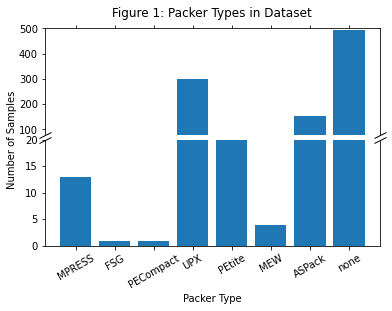

In [486]:
# get dataset packer statistics
packer_dict = {}

for data in packed_data:
    if data[1] in packer_dict:
        packer_dict[data[1]] += 1
    else:
        packer_dict[data[1]] = 1

# add the unpacked data
packer_dict["none"] = len(unpacked_data)

# plot the data on a graph
names = list(packer_dict.keys())
values = list(packer_dict.values())

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# plot the same data on both axes
ax1.bar(range(len(packer_dict)), values, tick_label=names)
ax2.bar(range(len(packer_dict)), values, tick_label=names)

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(80, 500)  # outliers only
ax2.set_ylim(0, 20)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# labels
plt.title("Figure 1: Packer Types in Dataset", y=2.1)
ax2.set_xlabel('Packer Type')
ax2.set_ylabel('Number of Samples', y=1, labelpad=8)

# prevent x-axis labels from running together
plt.xticks(rotation=30)

# show the plot
plt.show()

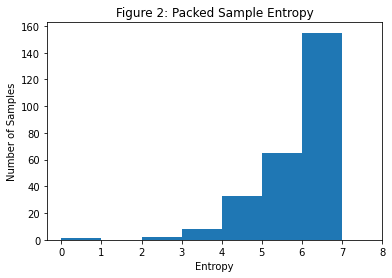

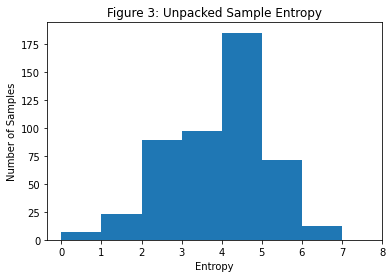

In [487]:
# entropy lists
packed_entropies = []
unpacked_entropies = []

# create entropy lists
for data in packed_data:
    packed_entropies.append(float(data[2]))

for data in unpacked_data:
    unpacked_entropies.append(float(data[2]))

# convert entropy lists to numpy arrays
packed_entropies = np.asarray(packed_entropies)
unpacked_entropies = np.asarray(unpacked_entropies)

# plot packed sample entropies
fig1,ax1 = plt.subplots(1,1)
ax1.hist(packed_entropies, bins = range(8))
ax1.set_title("Figure 2: Packed Sample Entropy")
ax1.set_xticks([0,1,2,3,4,5,6,7,8])
ax1.set_xlabel('Entropy')
ax1.set_ylabel('Number of Samples')
plt.show()

# plot unpacked sample entropies
fig2,ax2 = plt.subplots(1,1)
ax2.hist(unpacked_entropies, bins = range(8))
ax2.set_title("Figure 3: Unpacked Sample Entropy")
ax2.set_xticks([0,1,2,3,4,5,6,7,8])
ax2.set_xlabel('Entropy')
ax2.set_ylabel('Number of Samples')
plt.show()

In [488]:
"""
1.3 Dataset Cleaning
Author: Jackson Robbins, Wyatt Tauber

Convert the lists into numeric values supported by Numpy
"""
from sklearn.model_selection import train_test_split
import numpy as np

# create train/test splits of all of the data
total_data = packed_data + unpacked_data
train_set, test_set = train_test_split(total_data, test_size=0.4, random_state=7294802)

# create the label and data lists for the splits
train_label = []
test_label = []
train_data = []
test_data = []

for data in train_set:
    #  store the training labels
    if data[1] == "none":
        train_label.append(0)
    else:
        train_label.append(1)

    # store the training data
    train_data.append(float(data[2]))

for data in test_set:
    # store the testing labels
    if data[1] == "none":
        test_label.append(0)
    else:
        test_label.append(1)

    # store the testing data
    test_data.append(float(data[2]))

# convert the data to Numpy arrays
train_label = np.asarray(train_label)
test_label = np.asarray(test_label)
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)

## 2 Experiments & Results

Implement various ML models, tune hyperparameters, and present metrics. See the project PDF for details.

In [489]:
"""
2.1 Metrics
Author: Wyatt Tauber

Plot the accuracy versus hyperparameter values.
"""

def make_hp_plot(x_axis, acc_lst, prec_lst, rec_lst, f1_lst, x_label, title):
    """
    Make a hyperparameter tuning plot out of the metrics
    :param x_axis: x-axis scale
    :param acc_lst: list of accuracies the size of x
    :param prec_lst: list of precisions the size of x
    :param rec_lst: list of recalls the size of x
    :param f1_lst: list of F1-scores the size of x
    :param x_label: x-axis label
    :param title: graph title
    """
    fig, ax = plt.subplots()

    ax.plot(x_axis, acc_lst, label="Accuracy")
    ax.plot(x_axis, prec_lst, label="Precision")
    ax.plot(x_axis, rec_lst, label="Recall")
    ax.plot(x_axis, f1_lst, label="F1-Score")

    plt.title(title)
    plt.legend(loc='upper left')
    plt.xlabel(x_label)
    plt.ylabel("Metric Performance")
    plt.show()

def metric_lists_append(acc_lst, prec_lst, rec_lst, f1_lst, acc, prec, rec, f1):
    """
    Append the metrics to the metric lists
    :param acc_lst: accuracy list
    :param prec_lst: precision list
    :param rec_lst: recall list
    :param f1_lst: f1-score list
    :param acc: accuracy
    :param prec: precision
    :param rec: recall
    :param f1: f1-score
    :return: appended lists
    """
    acc_lst.append(acc)
    prec_lst.append(prec)
    rec_lst.append(rec)
    f1_lst.append(f1)

    return acc_lst, prec_lst, rec_lst, f1_lst

### 2.2 Logistic Regression

Logistic Regression Metrics:
Accuracy: 0.8860759493670886
Precision: 0.875
Recall: 0.9054726368159204
F1-score: 0.8899755501222493

Figure 4: Logistic Regression Confusion Matrix


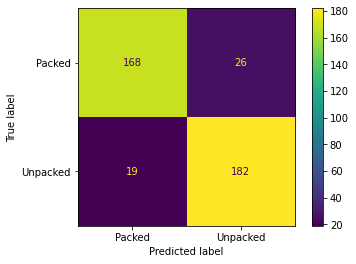

In [490]:
"""
2.2 Logistic Regression
Author: Jackson Robbins, Wyatt Tauber

An sklearn logistic regression implementation
"""
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# reshape the data into 2 dimensions
logistic_train_data = train_data.reshape(-1,1)
logistic_test_data = test_data.reshape(-1,1)

# perform logistic regression on the train data
logisticRegr = LogisticRegression()
logisticRegr.fit(logistic_train_data, train_label)

# make predictions on the test data
logistic_predictions = logisticRegr.predict(logistic_test_data)

# print the metrics
logistic_accuracy = accuracy_score(logistic_predictions, test_label)
logistic_precision = precision_score(logistic_predictions, test_label)
logistic_recall = recall_score(logistic_predictions, test_label)
logistic_f1 = f1_score(logistic_predictions, test_label)

print("Logistic Regression Metrics:")
print("Accuracy:", logistic_accuracy)
print("Precision:", logistic_precision)
print("Recall:", logistic_recall)
print("F1-score:", logistic_f1)

# create the confusion matrix
logistic_cf_matrix = confusion_matrix(logistic_predictions, test_label)
display = ConfusionMatrixDisplay(confusion_matrix=logistic_cf_matrix, display_labels=["Packed", "Unpacked"])
display.plot()

# display the confusion matrix
print("\nFigure 4: Logistic Regression Confusion Matrix")
plt.show()

### 2.3 Linear SVM

Linear SVM Metrics:
Accuracy: 0.8784810126582279
Precision: 0.875
Recall: 0.8921568627450981
F1-score: 0.883495145631068

Figure 5: Linear SVM Confusion Matrix


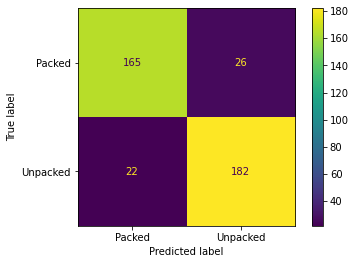

In [491]:
"""
2.3 Linear SVM
Author: Jackson Robbins, Wyatt Tauber

A sklearn linear SVM implementation
"""
from sklearn.svm import SVC

# reshape the data into 2 dimensions
svm_train_data = train_data.reshape(-1,1)
svm_test_data = test_data.reshape(-1,1)

# run linear SVM on the train data
clf = SVC(kernel='linear')
clf.fit(svm_train_data, train_label)

# make predictions on the test data
svm_predictions = clf.predict(svm_test_data)

# print the metrics
svm_accuracy = accuracy_score(svm_predictions, test_label)
svm_precision = precision_score(svm_predictions, test_label)
svm_recall = recall_score(svm_predictions, test_label)
svm_f1 = f1_score(svm_predictions, test_label)

print("Linear SVM Metrics:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)

# create the confusion matrix
svm_cf_matrix = confusion_matrix(svm_predictions, test_label)
display = ConfusionMatrixDisplay(confusion_matrix=svm_cf_matrix, display_labels=["Packed", "Unpacked"])
display.plot()

# display the confusion matrix
print("\nFigure 5: Linear SVM Confusion Matrix")
plt.show()

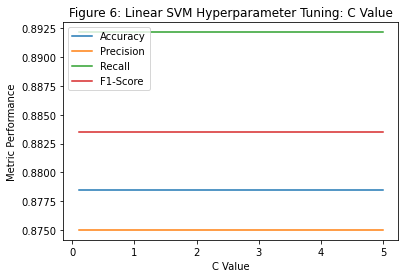

/home/wyatt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


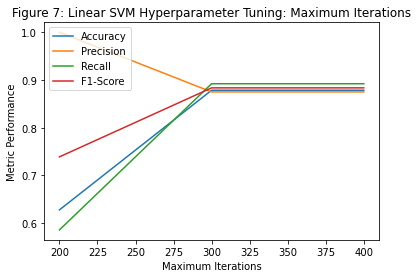

In [492]:
# Hyperparameter tuning

# adjusting C
svm_acc, svm_prec, svm_rec, svm_f1 = 0, 0, 0, 0
svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst = [], [], [], []
x = np.arange(0.1, 5.1, 0.1)
x_c = [*x]

for c_i in x:
    # run linear SVM on the train data
    clf = SVC(kernel='linear', C=c_i)
    clf.fit(svm_train_data, train_label)

    # make predictions on the test data
    svm_predictions = clf.predict(svm_test_data)

    # get the metrics
    svm_acc = accuracy_score(svm_predictions, test_label)
    svm_prec = precision_score(svm_predictions, test_label)
    svm_rec = recall_score(svm_predictions, test_label)
    svm_f1 = f1_score(svm_predictions, test_label)

    svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst = \
        metric_lists_append(svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst,
                            svm_acc, svm_prec, svm_rec, svm_f1)

make_hp_plot(x_c, svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst, "C Value", "Figure 6: Linear SVM Hyperparameter Tuning: C Value")

# adjusting max_iter
svm_acc, svm_prec, svm_rec, svm_f1 = 0, 0, 0, 0
svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst = [], [], [], []
x = np.arange(200, 500, 100)
x_mi = [*x]

for mi_i in x:
    # run linear SVM on the train data
    clf = SVC(kernel='linear', max_iter=mi_i)
    clf.fit(svm_train_data, train_label)

    # make predictions on the test data
    svm_predictions = clf.predict(svm_test_data)

    # get the metrics
    svm_acc = accuracy_score(svm_predictions, test_label)
    svm_prec = precision_score(svm_predictions, test_label)
    svm_rec = recall_score(svm_predictions, test_label)
    svm_f1 = f1_score(svm_predictions, test_label)

    svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst = \
        metric_lists_append(svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst,
                            svm_acc, svm_prec, svm_rec, svm_f1)

make_hp_plot(x_mi, svm_acc_lst, svm_prec_lst, svm_rec_lst, svm_f1_lst, "Maximum Iterations", "Figure 7: Linear SVM Hyperparameter Tuning: Maximum Iterations")

### 2.4 Naive Bayes

Naive Bayes Metrics:
Accuracy: 0.8556962025316456
Precision: 0.7644230769230769
Recall: 0.9520958083832335
F1-score: 0.8480000000000001

Figure 8: Naive Bayes Confusion Matrix


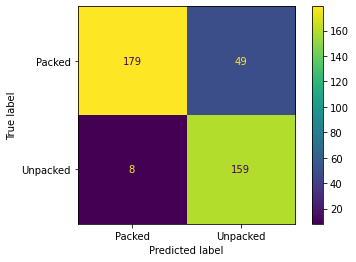

In [493]:
"""
2.4 Naive Bayes
Author: Wyatt Tauber

A sklearn Naive Bayes implementation
"""
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

# reshape the data into 2 dimensions
nb_train_data = train_data.reshape(-1,1)
nb_test_data = test_data.reshape(-1,1)

# run Naive Bayes on the training data
nb = CategoricalNB()
nb.fit(nb_train_data, train_label)

# make predictions on the test data
nb_predictions = nb.predict(nb_test_data)

# print the metrics
nb_accuracy = accuracy_score(nb_predictions, test_label)
nb_precision = precision_score(nb_predictions, test_label)
nb_recall = recall_score(nb_predictions, test_label)
nb_f1 = f1_score(nb_predictions, test_label)

print("Naive Bayes Metrics:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-score:", nb_f1)

# create the confusion matrix
nb_cf_matrix = confusion_matrix(nb_predictions, test_label)
display = ConfusionMatrixDisplay(confusion_matrix=nb_cf_matrix, display_labels=["Packed", "Unpacked"])
display.plot()

# display the confusion matrix
print("\nFigure 8: Naive Bayes Confusion Matrix")
plt.show()